### Inventory Simulation
#### INF1036 - 3WA

Fernando Homem, Júlia Aleixo, Pedro Moraes, Rafael Rubim

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats
from ipywidgets import FloatProgress
from IPython.display import display

%matplotlib inline

#### Variable declarations

In [2]:
T = 6.0
S = 15 # maximum on-hand inventory
s = 5 # minimum on-hand inventory
x0 = 15 # initial amount of inventory
r = 30 # price per product unit
L = 2 # units of time before order arrives
h = 2 # inventory holding cost
ratemax = 20

#### Cost function
Defines the cost of ordering y units of the product.

In [3]:
def cost(y): 
    return y * r

#### Customer's arrivals
Customers demanding the product appear in accordance with a non-homogenous Poisson process with rate λ.

In [4]:
def rate(t):
    if (t < 1.0):
        return 10.0
    elif (t < 2.0):
        return 5.0
    elif (t < 3.0):
        return 10.0
    elif (t < 4.0):
        return 2.0
    elif (t < 5.0):
        return 5.0
    else:
        return 10.0

In [5]:
def exponential(nsamples,rate):
    x = np.zeros(nsamples)
    u = np.random.sample(nsamples)
    for i in range(nsamples):
        x[i] = - math.log(1.0 - u[i]) / rate
    return x

In [6]:
def nextArrival(t,rate,ratemax):
    while(1):
        Z = exponential(1,ratemax)[0]
        t = t + Z
        U = np.random.sample(1)
        if U < rate(t) / ratemax:
            return t

#### Inventory Model
Returns the average profit per unit of time.

In [7]:
def inventory(G,T,S,s,c,x0,r,L,h,rate,ratemax):
    
    C = 0.0 # total amount of ordering costs
    R = 0.0 # total amount of revenue earned
    H = 0.0 # total amount of inventory holding costs
    x = x0 # amount of inventory
    y = 0 # amount on order
    t = 0.0 
    t0 = nextArrival(t,rate,ratemax) # arrival time of next customer
    t1 = 1.0e+30 # time of order delivery
    T0 = []
    T1 = []
    
    while(1):
        
        # customer arrives before delivery
        if t0 < t1 and t < T:
            H = H + (t0 - t) * x * h
            t = t0
            T0.append(t0)
            D = G(1,rate(t))[0] # customer's demand
            w = min(D,x) # amount of the order that can be filled
            R = R + w * r
            x = x - w
            if x < s and y == 0:
                y = S - x
                t1 = t + L
            U = np.random.sample(1)[0]
            t0 = t - (1 / rate(t)) * math.log(U)
#             print("t0: " + str(t0))
#             print("t1: " + str(t1))

        elif t1 <= t0 and t < T:
            H = H + (t1 - t) * x * h
            t = t1
            T1.append(t1)
            C = C + c(y)
            x = x + y
            y = 0
            t1 = 1.0e+30
            
        else:
#             print("R: " + str(R))
#             print("C: " + str(C))
#             print("H: " + str(H))
            profit = (R - C - H) / T # profit per unit time
            return profit, T0, T1

In [8]:
profit,T0,T1 = inventory(exponential,T,S,s,cost,x0,r,L,h,rate,ratemax)
print(profit)
print(T0)
print(T1)

0.5607254668512761
[0.012123921683579267, 0.07843763625707183, 0.2127695531817565, 0.23993701058164024, 0.2633432818214001, 0.5694648609379895, 0.5970882673165521, 0.8418978740569059, 0.9184822117937493, 0.9594548934046281, 1.1958394010026911, 1.2115560807930101, 1.2499107036510697, 1.4315907961074679, 1.51455116035317, 1.6373768707532304, 1.9032458288525258, 2.108065852286363, 2.1466807573651594, 2.2956245977119782, 2.3590834631276247, 2.5416838060163807, 2.5637242484941467, 2.6587729134755076, 2.6762028764004264, 2.74571486433939, 2.885864843119965, 2.909957247531269, 3.008673603590237, 4.006909578895511, 4.073064065931037, 4.244034360919824, 4.252072470117259, 4.335880533481276, 4.344446038512581, 5.018425020569107, 5.095296346942829, 5.186824466757826, 5.262161663204281, 5.449510822365162, 5.625284768623661, 6.031036330654653]
[]


#### Tests

In [11]:
def inventoryTolerance(tol,alpha):
    x = np.zeros(100)
    for i in range(100):
        profit,T0,T1 = inventory(exponential,T,S,s,cost,x0,r,L,h,rate,ratemax)
        x[i] = profit
    n  = 100
    m  = np.mean(x)
    s2 = np.var(x)
    zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
    while(2.0 * (s2 / n) * zab2 * zab2 > tol**2):
        nx,T0,T1 = inventory(exponential,T,S,s,cost,x0,r,L,h,rate,ratemax)
        nm  = m + (nx - m) / (n + 1)
        ns2 = (1.0 - 1.0 / n) * s2 + (n + 1.0) * (nm - m)**2
        n = n + 1
        m  = nm
        s2 = ns2 
        x = np.append(x,nx)
    return m,s2,n,x

In [12]:
tol = 0.1
alpha = 0.05

m,s2,n,x = inventoryTolerance(tol,alpha)
print("Average profit per unit of time: " + str(m))
print(s2)
print("Number of necessary scenarios: " + str(n))
zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
print("The average is in the interval [" + str(m - math.sqrt(s2 / n) * zab2) + "," + str(m + math.sqrt(s2 / n) * zab2) \
      + "] with a probability of " + str(1.0 - alpha) + ".")

Average profit per unit of time: 6.314515511156928
93.86233240968548
Number of necessary scenarios: 124554
The average is in the interval [6.243805010716777,6.38522601159708] with a probability of 0.99.


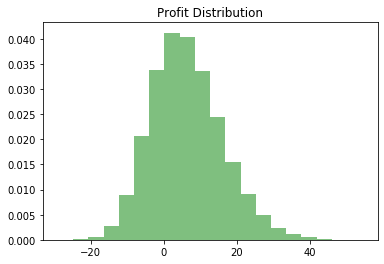

In [28]:
plt.hist(x, 20, density = 1, facecolor ='green', alpha = 0.5)
plt.title("Profit Distribution")
plt.show()

#### Ordering Policy

By varying the values of S and s, we are able to determine the ordering policy that maximizes the store's profits.

In [31]:
f = FloatProgress(min = 0, max = 100)
display(f)
f.description = "Progress"

maximum_profit = -1.0e+30
best_S = 0
best_s = 0

for S in range(10,20):
    for s in range(20,10,-1):
        m,s2,n,x = inventoryTolerance(tol,alpha)
        if m > maximum_profit:
            maximum_profit = m
            best_S = S
            best_s = s
        f.value = f.value + 1
            
print("Maximum profit: " + str(maximum_profit))
print("Best ordering policy (s,S): (" + str(best_s) + "," + str(best_S) + ")")

FloatProgress(value=0.0)

Maximum profit: 24.898157994596307
Best ordering policy (s,S): (19,10)
